# RFMSPPL clustering using DBSCAN

DBSCSAN stands for "Density-Based Spatial Clustering of Applications with Noise", it's proved efficient when your data may have outliers
or with skewed datasets.

In [11]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

rfmsppl = pd.read_csv("./../../../output/rfmsppl.csv")
y = rfmsppl["review_score"]

X_train, X_test, y_train, y_test = train_test_split(
    rfmsppl, y, test_size=0.2, random_state=42, stratify=y
)
rfmsppl = X_test

rfmsppl

recency  frequency  monetary  nb_orders          first_order  \
86359    147.0   0.166667    143.56        1.0  2018-04-04 21:53:53   
42247    174.0   0.142857    159.03        1.0  2018-03-08 16:13:44   
70502    114.0   0.200000    701.66        1.0  2018-05-07 22:52:58   
1832     167.0   0.142857    184.56        1.0  2018-03-16 09:17:05   
18729    583.0   0.050000     91.07        1.0  2017-01-24 09:24:11   
...        ...        ...       ...        ...                  ...   
36084     67.0   0.333333     84.87        1.0  2018-06-23 17:11:17   
6        132.0   0.200000     35.38        1.0  2018-04-20 12:57:23   
50280    220.0   0.125000    116.85        1.0  2018-01-22 12:57:49   
6970     235.0   0.111111    464.05        1.0  2018-01-06 23:01:03   
53369     37.0   0.500000     29.22        1.0  2018-07-24 12:59:07   

                last_order  days_between_orders  scoring_R  scoring_F  \
86359  2018-04-04 21:53:53                    0          4          4   
42247  2018-03-08 16:13:44                    0          4          3   
70502  2018-05-07 22:52:58                    0          4          4   
1832   2018-03-16 09:17:05                    0          4          3   
18729  2017-01-24 09:24:11                    0          1          1   
...                    ...                  ...        ...        ...   
36084  2018-06-23 17:11:17                    0          5          5   
6      2018-04-20 12:57:23                    0          4          4   
50280  2018-01-22 12:57:49                    0          3          3   
6970   2018-01-06 23:01:03                    0          3          3   
53369  2018-07-24 12:59:07                    0          5          5   

       scoring_M  scoring_RFM        segment_RFM  review_score  \
86359          4           12       Bons clients           5.0   
42247          4           11       Bons clients           3.0   
70502          5           13  Très bons clients           5.0   
1832           4           11       Bons clients           1.0   
18729          3            5     Clients tièdes           4.0   
...          ...          ...                ...           ...   
36084          2           12       Bons clients           5.0   
6              1            9       Bons clients           4.0   
50280          3            9       Bons clients           5.0   
6970           5           11       Bons clients           4.0   
53369          1           11       Bons clients           4.0   

       review_completion_percentage   review_behavior  nb_products  \
86359                     33.333333  Best Contributor            3   
42247                     66.666667  Best Contributor            1   
70502                    100.000000  Best Contributor            1   
1832                      66.666667  Best Contributor            1   
18729                     66.666667  Best Contributor            1   
...                             ...               ...          ...   
36084                     66.666667  Best Contributor            1   
6                         33.333333  Best Contributor            1   
50280                     33.333333  Best Contributor            1   
6970                      33.333333  Best Contributor            1   
53369                     66.666667  Best Contributor            1   

       customer_zip_code_prefix          customer_city customer_state  
86359                      6315            carapicuiba             SP  
42247                      7841        franco da rocha             SP  
70502                     18045               sorocaba             SP  
1832                      23071         rio de janeiro             RJ  
18729                     38735  cruzeiro da fortaleza             MG  
...                         ...                    ...            ...  
36084                     66030                  belem             PA  
6                         13084               campinas             

It's not required by DBSCAN to have variables with normal distributions, but it never hurt to scale our variables:

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

encoder = OneHotEncoder()
ordinal_vars = rfmsppl[rfmsppl.select_dtypes(include=["object", "category"]).columns]
encoder.fit(ordinal_vars)

encoded_customers = encoder.transform(ordinal_vars)
scalar_vars = rfmsppl[
    rfmsppl.select_dtypes(exclude=["object", "category"]).columns
].values

scaler = StandardScaler()

scalar_vars = pd.concat(
    [pd.DataFrame(scalar_vars), pd.DataFrame(encoded_customers)], axis=1
)
scaler.fit(scalar_vars)

scaled_customers = scaler.transform(scalar_vars)

scaled_customers

We need to determine the optimal value for epsilon (eps) and the number of samples (min_samples).
Two points are considered neighbors if the distance between the two points is below the threshold epsilon.

As stated by most of data scientists, you may chose the number of samples according to your business.
If you have no idea about the number of clusters for this kind of business, you can apply the [following formula](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf):

min_samples = 2 * (number of variables)

In our case, we have 13 variables so we select **26** as `min_samples` value.

Then we will estimate an optimal value for epsilon.

In [12]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=26).fit(scaled_customers)
distances, idx = nearest_neighbors.kneighbors(scaled_customers)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
fig = px.line(None, y=distances, title="Evaluation of epsilon")
fig.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 369


It look likes a value of eps around [3-5] is optimal.

eps  n_clusters  noise_points  silhouette_score
0   3.0           4           382          0.330785
1   3.2           3           267          0.391540
2   3.4           3           165          0.416737
3   3.6           3           133          0.422231
4   3.8           3           108          0.422507
5   4.0           3            92          0.425152
6   4.2           3            81          0.428739
7   4.4           3            70          0.432598
8   4.6           3            61          0.435746
9   4.8           3            50          0.438691
10  5.0           3            38          0.448385
11  5.2           3            31          0.454460
12  5.4           3            30          0.455857
13  5.6           3            27          0.457582
14  5.8           3            27          0.457582

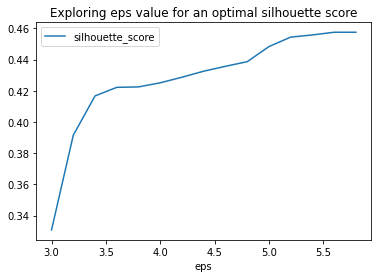

In [13]:
from sklearn import metrics
import numpy as np

# Compute DBSCAN
report = []
for eps_value in np.arange(3, 6, 0.2):
    dbscan = DBSCAN(eps=eps_value, min_samples=26, n_jobs=-1).fit(scaled_customers)
    labels = dbscan.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    score = metrics.silhouette_score(scaled_customers, labels)
    report.append(
        {
            "eps": eps_value,
            "n_clusters": n_clusters_,
            "noise_points": n_noise_,
            "silhouette_score": score,
        }
    )

df_report = pd.DataFrame(report)
df_report.plot(
    title="Exploring eps value for an optimal silhouette score",
    x="eps",
    y="silhouette_score",
)

df_report.head(15)

An optimal eps value is : **1.5** for **3** clusters

In [14]:
# Compute DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=26).fit(scaled_customers)
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(
    "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(scaled_customers, labels)
)

Estimated number of clusters: 5
Estimated number of noise points: 2868
Silhouette Coefficient: 0.111


In [15]:
rfmsppl["cluster"] = labels
rfmsppl.cluster = rfmsppl.cluster.astype("category")

#### Clustering visualisation

In [16]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, learning_rate="auto", init="random", n_jobs=-1)
projected_customers = tsne.fit_transform(scaled_customers)

fig = px.scatter(
    projected_customers,
    x=0,
    y=1,
    color=rfmsppl.cluster,
    labels={"color": "cluster"},
    opacity=0.8,
)
fig.show()

In [17]:
# cluster for value equals to -1 is noise
dataset = rfmsppl[rfmsppl.cluster != -1]
fig = px.scatter_3d(dataset, x="recency", y="monetary", z="frequency", color="cluster")
fig.show()

### Conclusions on DBSCAN

Sadly, as we can see the frequency have the biggest impact and there is nothing more we can learn from this clustering if we use only RFM metrics.
If we want a better clustering, we must integrate more data.